In [1]:
# Imports
import numpy as np
import altair as alt
import pydot
from IPython.display import display, SVG, clear_output, HTML
import matplotlib.pyplot as plt

from pydrake.all import *
from pydrake.examples.manipulation_station import ManipulationStation

from manipulation import running_as_notebook
from manipulation.meshcat_cpp_utils import (
    StartMeshcat, MeshcatJointSlidersThatPublish)
from manipulation.scenarios import AddMultibodyTriad, SetColor

import pandas as pd

import torch
import joblib
import json

In [2]:
# Start the visualizer.
meshcat = StartMeshcat()

In [3]:
# Define the number of actuators
na = 5
# To set
# kv, Kt, km, Kv, tau_mu, b0

In [4]:
# Defining the actuator box
class ActuatorBox(LeafSystem):
    def __init__(self, tau_max_dv, omega_max_dv, gear_ratio):
        LeafSystem.__init__(self)
        # Both the values are motor specific NOT joint specific
        self.tau_max = tau_max_dv*gear_ratio
        # Convert RPM of motor to joint velocity in rad/sec
        self.omega_max = omega_max_dv*2*np.pi/60/gear_ratio
        self.DeclareVectorInputPort('commanded_torque', BasicVector(na))
        self.DeclareVectorInputPort('joint_state', BasicVector(2*na))
        self.DeclareVectorOutputPort('realised_torque', BasicVector(na), self.OutputJointTorque)

    def OutputJointTorque(self, context, output):
        # Get the state values
        q = self.EvalVectorInput(context, 1).get_value()
        qvel = q[na:]
        # Define a Kv (slope of plot between omega and tau)
        u = self.EvalVectorInput(context, 0).get_value()
        # Compute the instantaneous torque limit
        # For the AK-70-10 motors
        kv = 0.111
        u_new = np.copy(u)
        # Using URDF safety controller rules
        for i in range(len(u)):
            if qvel[i]>=0 and u[i]>=0:
                u_bound = -kv*(qvel[i]-self.omega_max)
                u_new[i] = np.minimum(u[i], u_bound)
            if qvel[i]>=0 and u[i]<=0:
                u_bound = -self.tau_max
                u_new[i] = np.maximum(u[i], u_bound)
            if qvel[i]<=0 and u[i]>=0:
                u_bound = self.tau_max
                u_new[i] = np.minimum(u[i], u_bound)
            if qvel[i]<=0 and u[i]<=0:
                u_bound = -(-kv*(np.abs(qvel[i])-self.omega_max))
                u_new[i] = np.maximum(u[i], u_bound)
        output.SetFromVector(u)

In [19]:
# Define task variables
cartd = np.array([-0.35, 0, 0.75])
carti = np.array([0, 0.2, 0.55])

sim_time = 5
error_threshold = 5e-3
# Friction torque
tau_mu = 5.3e-3
b0 = 1.5e-5
# From the AK-70 motors
# Motor constant matrix
km = 0.19
# Costant matrix for tau->joule_loss
K = 1/np.sqrt(km)*np.identity(na)
Kt = 0.095
Kv = 100

# Define other variables
Kp_sample = 15
# Kd_sample = 2*np.sqrt(Kp_sample)
gear_ratio = 10
# motor values
taumax = 8.3/gear_ratio
omegamax = 475*gear_ratio

print('taumax: ', taumax)
print('omegamax: ', omegamax)
print('Kp_sample: ', Kp_sample)
# print('Kd_sample: ', Kd_sample)
print('gear_ratio: ', gear_ratio)

urdf_path = './urdfs/DIVAR2V/urdf/DIVAR2V.urdf'

taumax:  0.8300000000000001
omegamax:  4750
Kp_sample:  15
gear_ratio:  10


In [22]:
meshcat.Delete()
meshcat.DeleteAddedControls()

builder = DiagramBuilder()
time_step = 1e-4
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=time_step)
model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
# Set robot near table
X_R = RigidTransform(RotationMatrix.MakeYRotation(0), np.array([-0.1, 0.5, 1]))
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
# Set sphere to desired position
sphere1 = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere1')
X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), carti)
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere1)[0]).body_frame(), X_R)

sphere2 = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere2')
X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), cartd)
plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere2)[0]).body_frame(), X_R)
plant.Finalize()        
actuator = builder.AddSystem(ActuatorBox(taumax, omegamax, gear_ratio))

In [23]:
# Draw the frames
for body_name in ["base_link", "eef"]:
#     for body_name in ["base_link", "elbow", "shoud2", "should1", "under arm", "upper arm", "eef"]:
    AddMultibodyTriad(plant.GetFrameByName(body_name, model), scene_graph)

# Adds the MeshcatVisualizer and wires it to the SceneGraph.
visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

Kp = np.full(na, Kp_sample)
Ki = np.full(na, 0)
Kd = 2*np.sqrt(Kp)

iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, Kp, Ki, Kd, False))
iiwa_controller.set_name("iiwa_controller");
builder.Connect(plant.get_state_output_port(model),
                iiwa_controller.get_input_port_estimated_state())

# Add a motor characteristics box here to define how the motor output would be based on the commanded control 
builder.Connect(iiwa_controller.get_output_port_control(), 
                actuator.get_input_port(0))
builder.Connect(plant.get_state_output_port(model),
                actuator.get_input_port(1))
builder.Connect(actuator.get_output_port(),  plant.get_actuation_input_port())

# Connecting a data logger
# Commanded torque
logger1 = LogVectorOutput(iiwa_controller.get_output_port_control(), builder)
# Joint state
logger2 = LogVectorOutput(plant.get_state_output_port(model), builder)
# Realised torque
logger3 = LogVectorOutput(actuator.get_output_port(), builder)

diagram = builder.Build()

In [24]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
# q0 = plant.GetPositions(plant_context)
# q0 = np.array([-0.88, -1, -0.9, 0.97, -0.31])
q0 = np.array([2.83, 0.02, 2.58, -0.55, 0.44])
gripper_frame = plant.GetBodyByName("eef").body_frame()
# diagram.Publish(context)

In [25]:
# q0 = np.array([2.83, 0.02, 2.58, -0.55, 0.44])
# qd = np.array([2.16, 0.19, 2.87, -0.42, -0.28])
# Finding the joint poses from the Cartesian locations of the eef
# Pose-1
# carti = np.array([-0.21, 0.18, 0.65])
# orii = np.array([-2.93, -0.88, -1.09])
# Rii = RotationMatrix(RollPitchYaw(orii))
# # Pose-2
# cartd = np.array([-0.25, 0.33, 0.45])
# orid = np.array([-2.8, -0.60, -0.87])
# Rd = RotationMatrix(RollPitchYaw(orid))
# Compute IK
ik = InverseKinematics(plant, plant_context)
# position constraint
ik.AddPositionConstraint(
            gripper_frame, [0, 0, 0], plant.world_frame(), 
            carti, carti)
# orientation constraint
# ik.AddOrientationConstraint(
#     gripper_frame, RotationMatrix(), plant.world_frame(), 
#     Rii, 0.0)
prog = ik.get_mutable_prog()
q = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(q)), q0, q)
prog.SetInitialGuess(q, q0)
result = Solve(ik.prog())
qinit = result.GetSolution(ik.q())
# Condition the final angles to be between -pi and pi
qinit = (np.arctan2(np.sin(qinit), np.cos(qinit)))
print('init pose IK: ', result.is_success(),' ', qinit )

# Compute ik for pose-2
ik = InverseKinematics(plant, plant_context)
ik.AddPositionConstraint(
            gripper_frame, [0, 0, 0], plant.world_frame(), 
            cartd, cartd)
# ik.AddOrientationConstraint(
#     gripper_frame, RotationMatrix(), plant.world_frame(), 
#     Rd, 0.0)
prog = ik.get_mutable_prog()
q = ik.q()
prog.AddQuadraticErrorCost(np.identity(len(q)), qinit, q)
prog.SetInitialGuess(q, qinit)
result = Solve(ik.prog())
qd = result.GetSolution(ik.q())
# Condition the final angles to be between -pi and pi
qd = (np.arctan2(np.sin(qd), np.cos(qd)))
print('final pose IK: ', result.is_success(),' ', qd)
# diagram.Publish(context)

init pose IK:  True   [ 2.41344136 -0.17609652  2.50633341 -0.67085253  0.44      ]
final pose IK:  True   [ 2.96961015  0.54321489  2.53569802 -0.48132865  0.44      ]


In [26]:
# Or define desired positions in joint space since we have only one robot here
# qi = np.array([2.83, 0.02, 2.58, -0.55, 0.44])
# qd = np.array([2.16, 0.19, 2.87, -0.42, -0.28])

# Check for applied force
G = plant.GetBodyByName("eef").body_frame()
W = plant.world_frame()
# If we can reach the final position, set that as the robots position
plant.SetPositions(plant.GetMyContextFromRoot(context), model, qd)
J_G = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kV, G, [0,0,0], W, W)
# Required force in global frame
force_applied = np.array([0,0,0,0,0,10])
force_projection = np.matmul(J_G.transpose(), force_applied)
print('force_projection: ', force_projection)

# Calculate the gravity generalised forces
Gvec = plant.CalcGravityGeneralizedForces(plant_context)
print('Gvec: ', Gvec)
joint_torques = -Gvec-force_projection

print('joint_torques: ', joint_torques)
print(np.max(np.abs(joint_torques)))
# diagram.Publish(context)

force_projection:  [ 5.00000000e+00  1.92092274e-01  1.64572769e+00 -1.16344095e+00
  6.93889390e-17]
Gvec:  [-2.37637379e+00 -2.08813413e-01 -2.09570898e-01  1.48663633e-01
 -1.14158856e-05]
joint_torques:  [-2.62362621e+00  1.67211392e-02 -1.43615680e+00  1.01477732e+00
  1.14158856e-05]
2.6236262148261478


In [27]:
G = plant.GetBodyByName("eef").body_frame()
# For payload computation
fully_stretched = np.array([1.57,1.57,0,-1.3,0])
plant.SetPositions(plant.GetMyContextFromRoot(context), model,
              fully_stretched)
J_G = plant.CalcJacobianSpatialVelocity(plant_context, JacobianWrtVariable.kV, G, [0,0,0], W, W)
# Lift a weight of 10N (1kg payload)
# Applied force should be in W frame
force_applied = np.array([0,0,0,0,0,-10])
force_projection = np.matmul(J_G.transpose(), force_applied)
print('force_projection: ', force_projection)

# Calculate the gravity generalised forces
Gvec = plant.CalcGravityGeneralizedForces(plant_context)
print('Gvec: ', Gvec)
joint_torques = -Gvec-force_projection

print('joint_torques: ', joint_torques)
print(np.max(np.abs(joint_torques)))
# diagram.Publish(context)

force_projection:  [ 7.52726849e-02 -6.20176948e+00 -1.52066788e-02 -3.18920282e+00
 -2.83518868e-16]
Gvec:  [ 1.26670380e-01 -2.87760894e+00 -6.81761191e-03 -4.09582575e-01
 -2.45731840e-08]
joint_torques:  [-2.01943065e-01  9.07937842e+00  2.20242908e-02  3.59878540e+00
  2.45731843e-08]
9.079378419924424


In [28]:
#  SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg())

In [29]:
xd = np.hstack((qd, 0*qd))
plant.SetPositions(plant_context, qinit)
iiwa_controller.GetInputPort('desired_state').FixValue(
iiwa_controller.GetMyMutableContextFromRoot(context), xd)
diagram.Publish(context)

In [30]:
simulator = Simulator(diagram, context)
simulator.AdvanceTo(sim_time);

In [31]:
# Now we want to get the simulation data, i.e., 
# the torque applied, final time and the 
log1 = logger1.FindLog(context)
log2 = logger2.FindLog(context)
log3 = logger3.FindLog(context)

In [32]:
error = np.abs(log2.data()[:na,:].transpose() - np.tile(qd,(log3.data().shape[1],1)))
e_norm = np.array([np.linalg.norm(val) for val in error])
print(e_norm[-1])

1.1708426661576514


In [33]:
omega_j = []
for i in range(log2.data().shape[1]):
    omega_j.append(log2.data()[:,i][na:])
omega_j = np.array(omega_j).transpose()
omega_m = omega_j*gear_ratio
# Convert the motor speed to RPM
omega_m_rpm = omega_m*60/(2*np.pi)
# Motor torque realised
tau_m = log3.data()/gear_ratio

max RPM: 1.0266178860721011


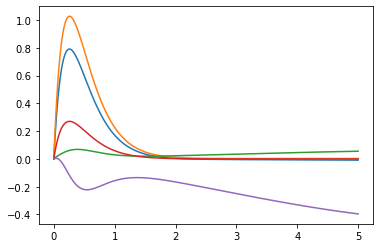

In [34]:
# Angular angular velocity of the robot in RPM
plt.plot(log2.sample_times(), omega_j[0, :], log2.sample_times(), omega_j[1, :],\
        log2.sample_times(), omega_j[2, :], log2.sample_times(), omega_j[3, :], \
        log2.sample_times(), omega_j[4, :])
print('max RPM:', np.max(np.abs(omega_j)))

max RPM: 98.03478674095629


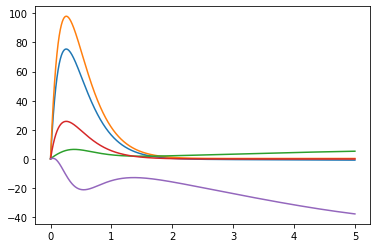

In [35]:
# Angular angular velocity of the robot in RPM
plt.plot(log2.sample_times(), omega_m_rpm[0, :], log2.sample_times(), omega_m_rpm[1, :],\
        log2.sample_times(), omega_m_rpm[2, :], log2.sample_times(), omega_m_rpm[3, :], \
        log2.sample_times(), omega_m_rpm[4, :])
print('max RPM:', np.max(np.abs(omega_m_rpm)))

In [36]:
# Total power loss
inst_friction_power = []
inst_joule_power = []
for i in range(len(log3.sample_times())):
    omega_inst = omega_m[:, i]
    tau_f = tau_mu*np.sign(omega_inst)+b0*omega_inst
    P_f = np.dot(tau_f, omega_inst)
    inst_friction_power.append(P_f)
    tau_t = tau_f+tau_m[:, i]
    P_t = np.dot(K.dot(tau_t), tau_t)
    inst_joule_power.append(P_t)

In [37]:
# Figure out how to compute these losses correctly!!!
total_friction_loss = np.sum(inst_friction_power)*time_step
total_joule_loss = np.sum(inst_joule_power)*time_step
print('total_friction_loss: ', total_friction_loss)
print('total_joule_loss: ', total_joule_loss)

total_friction_loss:  0.15271533423027936
total_joule_loss:  0.6544233844090159


In [38]:
# Final state of the robot
np.linalg.norm(qd-(log2.data()[:na, -1]))

1.1708426661576514

In [39]:
qd

array([ 2.96961015,  0.54321489,  2.53569802, -0.48132865,  0.44      ])

In [40]:
log2.data()[:na, -1]

array([ 2.94627717,  0.5547748 ,  2.69532137, -0.48353354, -0.71961632])

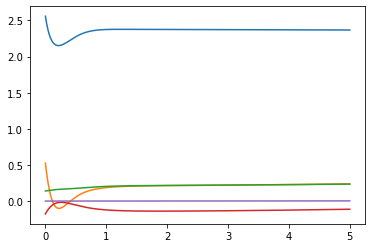

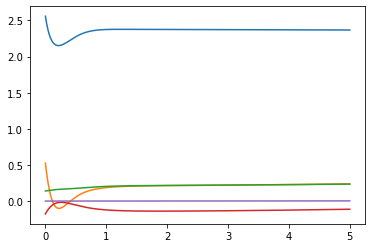

In [41]:
fig = plt.figure();
plt.plot(log1.sample_times(), log1.data()[0, :], log1.sample_times(), log1.data()[1, :],\
        log1.sample_times(), log1.data()[2, :], log1.sample_times(), log1.data()[3, :], \
        log1.sample_times(), log1.data()[4, :]);

fig = plt.figure();
plt.plot(log3.sample_times(), log3.data()[0, :], log3.sample_times(), log3.data()[1, :],\
        log3.sample_times(), log3.data()[2, :], log3.sample_times(), log3.data()[3, :], \
        log3.sample_times(), log3.data()[4, :]);

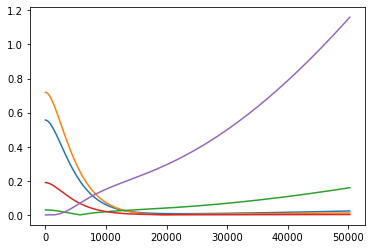

In [42]:
error = np.abs(log2.data()[:na,:].transpose() - np.tile(qd,(log3.data().shape[1],1)))
plt.plot(error);

In [43]:
e_norm = np.array([np.linalg.norm(val) for val in error])
for i in range(len(e_norm)):
    if np.all(e_norm[i:]<5e-3):
        print(i)
        break

ts = log2.sample_times()[i]
print(ts)

5.0


In [44]:
# Max torque required
# We can enforce max torque requirements at each joint in the URDF itself
print(np.max(np.abs(log1.data())))
print(np.max(np.abs(log3.data())))

2.5574333008658936
2.5574333008658936


In [45]:
inst_power_m = []
Kt = 0.068
Kv = 140
for i in range(len(log3.sample_times())):
    # Compute inst power demanded
#     inst_power_m.append(np.abs(np.multiply(tau_m[:,i], omega_m_rpm[:,i]))/(Kt*Kv))
    inst_power_m.append(np.multiply(tau_m[:,i], omega_m_rpm[:,i])/(Kt*Kv))

max power used:  1.7117031458174314 W


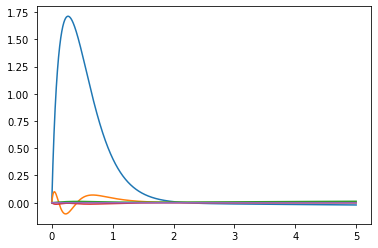

In [46]:
# The joule losses feel very high, is this common or is
plt.plot(log3.sample_times(), inst_power_m)
print("max power used: ", np.max(np.abs(inst_power_m)), "W")

max power used:  0.16517306471105314 W


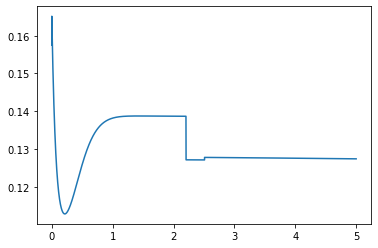

In [47]:
# The joule losses feel very high, is this common or is
plt.plot(log1.sample_times(), inst_joule_power)
print("max power used: ", np.max(inst_joule_power), "W")

In [48]:
print(total_friction_loss)
print(total_joule_loss)

0.15271533423027936
0.6544233844090159


In [ ]:
# Compute cost
print(1+1+1+ts+total_friction_loss+total_joule_loss)

In [ ]:
def gripper_forward_kinematics_example():
    urdf_path = './urdfs/DIVAR2V/urdf/DIVAR2V.urdf'
    builder = DiagramBuilder()
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    model = Parser(plant, scene_graph).AddModelFromFile(urdf_path, 'diva_robot')
    # Transform for the robot location
    X_R = RigidTransform(RotationMatrix.MakeYRotation(0), np.array([-0.1, 0.5, 1.25]))
#     X_R = RigidTransform(RotationMatrix(RollPitchYaw([0.8, -0.8, 0])), np.array([-0.1, 0.5, 1]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(model)[0]).body_frame(), X_R)
    # Spawn table
    table = Parser(plant, scene_graph).AddModelFromFile('./urdfs/table/extra_heavy_duty_table_modified.sdf','table')
    # Spawn spherical work piece
    sphere = Parser(plant, scene_graph).AddModelFromFile('./urdfs/helper/sphere.urdf','sphere')
    # Place the sphere at the center of the table
    # Length, width and height and thickness of the table
    # 1.39, 0.762, 0.736, 0.057
    # Sphere radius -- Can be made a design variable
    # 0.15
    # We can sample end-points on the surface of the sphere
    X_R = RigidTransform(RotationMatrix(RollPitchYaw([0, 0, 0])), np.array([0, 0, 0.736]))
    plant.WeldFrames(plant.world_frame(), plant.get_body(plant.GetBodyIndices(sphere)[0]).body_frame(), X_R)

    plant.Finalize()
    
    end_frame = "eef"
    
    # Draw the frames
    for body_name in ["base_link", end_frame]:
        AddMultibodyTriad(plant.GetFrameByName(body_name, model), scene_graph)

    meshcat.Delete()
    meshcat.DeleteAddedControls()

    visualizer = MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)

    diagram = builder.Build()
    context = diagram.CreateDefaultContext()

    plant.SetPositions(plant.GetMyContextFromRoot(context),
                  plant.GetModelInstanceByName("diva_robot"),
                  qi)
    
    gripper = plant.GetBodyByName(end_frame)
    def pose_callback(context):
        pose = plant.EvalBodyPoseInWorld(context, gripper)   ## This is the important line
        print(pose.translation())
        clear_output(wait=True)
        print("gripper position (m): " + np.array2string(
            pose.translation(), formatter={
                'float': lambda x: "{:3.2f}".format(x)}))
        print("gripper roll-pitch-yaw (rad):" + np.array2string(
            RollPitchYaw(pose.rotation()).vector(),
                         formatter={'float': lambda x: "{:3.2f}".format(x)}))
        print("pose rotation: ", pose.rotation())
    sliders = MeshcatJointSlidersThatPublish(meshcat, plant, visualizer, context)
    # sliders.Run()
    sliders.Run(pose_callback)

gripper_forward_kinematics_example()